In [ ]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline


# 강화 학습 (DQN) 튜토리얼
**Author**: [Adam Paszke](https://github.com/apaszke)
  **번역**: [황성수](https://github.com/adonisues)

이 튜토리얼에서는 [OpenAI Gym](https://www.gymlibrary.dev/)_ 의
CartPole-v0 태스크에서 DQN (Deep Q Learning) 에이전트를 학습하는데
PyTorch를 사용하는 방법을 보여드립니다.

**태스크**

에이전트는 연결된 막대가 똑바로 서 있도록 카트를 왼쪽이나 오른쪽으로
움직이는 두 가지 동작 중 하나를 선택해야 합니다.
다양한 알고리즘과 시각화 기능을 갖춘 공식 순위표를
[Gym 웹사이트](https://www.gymlibrary.dev/environments/classic_control/cart_pole)_ 에서 찾을 수 있습니다.

.. figure:: /_static/img/cartpole.gif
   :alt: cartpole

   cartpole

에이전트가 현재 환경 상태를 관찰하고 행동을 선택하면,
환경이 새로운 상태로 *전환* 되고 작업의 결과를 나타내는 보상도 반환됩니다.
이 태스크에서 매 타임스텝 증가마다 보상이 +1이 되고, 만약 막대가 너무 멀리
떨어지거나 카트가 중심에서 2.4 유닛 이상 멀어지면 환경이 중단됩니다.
이것은 더 좋은 시나리오가 더 오랫동안 더 많은 보상을 축적하는 것을 의미합니다.

카트폴 태스크는 에이전트에 대한 입력이 환경 상태(위치, 속도 등)를 나타내는
4개의 실제 값이 되도록 설계되었습니다. 그러나 신경망은 순수하게 그 장면을 보고
태스크를 해결할 수 있습니다 따라서 카트 중심의 화면 패치를 입력으로 사용합니다.
이 때문에 우리의 결과는 공식 순위표의 결과와 직접적으로 비교할 수 없습니다.
우리의 태스크는 훨씬 더 어렵습니다.
불행히도 모든 프레임을 렌더링해야되므로 이것은 학습 속도를 늦추게됩니다.

엄밀히 말하면, 현재 스크린 패치와 이전 스크린 패치 사이의 차이로 상태를 표시할 것입니다.
이렇게하면 에이전트가 막대의 속도를 한 이미지에서 고려할 수 있습니다.

**패키지**

먼저 필요한 패키지를 가져옵니다. 첫째, 환경을 위해
[gym](https://github.com/openai/gym)_ 이 필요합니다.

.. code-block:: bash
   %%bash
   pip3 install gym[classic_control]

또한 PyTorch에서 다음을 사용합니다:

-  신경망 (``torch.nn``)
-  최적화 (``torch.optim``)
-  자동 미분 (``torch.autograd``)
-  시각 태스크를 위한 유틸리티들 (``torchvision`` - [a separate
   package](https://github.com/pytorch/vision)_).


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


if gym.__version__ < '0.26':
    env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


## 재현 메모리(Replay Memory)

우리는 DQN 학습을 위해 경험 재현 메모리를 사용할 것입니다.
에이전트가 관찰한 전환(transition)을 저장하고 나중에 이 데이터를
재사용할 수 있습니다. 무작위로 샘플링하면 배치를 구성하는 전환들이
비상관(decorrelated)하게 됩니다. 이것이 DQN 학습 절차를 크게 안정시키고
향상시키는 것으로 나타났습니다.

이를 위해서 두개의 클래스가 필요합니다:

-  ``Transition`` - 우리 환경에서 단일 전환을 나타내도록 명명된 튜플.
   그것은 화면의 차이인 state로 (state, action) 쌍을 (next_state, reward) 결과로 매핑합니다.
-  ``ReplayMemory`` - 최근 관찰된 전이를 보관 유지하는 제한된 크기의 순환 버퍼.
   또한 학습을 위한 전환의 무작위 배치를 선택하기위한
   ``.sample ()`` 메소드를 구현합니다.



In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

이제 모델을 정의합시다. 그러나 먼저 DQN이 무엇인지 간단히 요약해 보겠습니다.

## DQN 알고리즘

우리의 환경은 결정론적이므로 여기에 제시된 모든 방정식은 단순화를 위해
결정론적으로 공식화됩니다. 강화 학습 자료은 환경에서 확률론적 전환에
대한 기대값(expectation)도 포함할 것입니다.

우리의 목표는 할인된 누적 보상 (discounted cumulative reward)을
극대화하려는 정책(policy)을 학습하는 것입니다.
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 여기서
$R_{t_0}$ 는 *반환(return)* 입니다. 할인 상수,
$\gamma$, 는 $0$ 과 $1$ 의 상수이고 합계가
수렴되도록 보장합니다. 에이전트에게 불확실한 먼 미래의 보상이
가까운 미래의 것에 비해 덜 중요하게 만들고, 이것은 상당히 합리적입니다.

Q-learning의 주요 아이디어는 만일 함수 $Q^*: State \times Action \rightarrow \mathbb{R}$ 를
가지고 있다면 반환이 어떻게 될지 알려줄 수 있고,
만약 주어진 상태(state)에서 행동(action)을 한다면, 보상을 최대화하는
정책을 쉽게 구축할 수 있습니다:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

그러나 세계(world)에 관한 모든 것을 알지 못하기 때문에,
$Q^*$ 에 도달할 수 없습니다. 그러나 신경망은
범용 함수 근사자(universal function approximator)이기 때문에
간단하게 생성하고 $Q^*$ 를 닮도록 학습할 수 있습니다.

학습 업데이트 규칙으로, 일부 정책을 위한 모든 $Q$ 함수가
Bellman 방정식을 준수한다는 사실을 사용할 것입니다:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

평등(equality)의 두 측면 사이의 차이는
시간차 오류(temporal difference error), $\delta$ 입니다.:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

오류를 최소화하기 위해서 [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_ 를 사용합니다.
Huber loss 는 오류가 작으면 평균 제곱 오차( mean squared error)와 같이
동작하고 오류가 클 때는 평균 절대 오류와 유사합니다.
- 이것은 $Q$ 의 추정이 매우 혼란스러울 때 이상 값에 더 강건하게 합니다.
재현 메모리에서 샘플링한 전환 배치 $B$ 에서 이것을 계산합니다:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-네트워크

우리 모델은 현재와 이전 스크린 패치의 차이를 취하는
CNN(convolutional neural network) 입니다. 두가지 출력 $Q(s, \mathrm{left})$ 와
$Q(s, \mathrm{right})$ 가 있습니다. (여기서 $s$ 는 네트워크의 입력입니다)
결과적으로 네트워크는 주어진 현재 입력에서 각 행동의 *기대값* 을 예측하려고 합니다.




In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Linear 입력의 연결 숫자는 conv2d 계층의 출력과 입력 이미지의 크기에
        # 따라 결정되기 때문에 따로 계산을 해야합니다.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### 입력 추출

아래 코드는 환경에서 렌더링 된 이미지를 추출하고 처리하는 유틸리티입니다.
이미지 변환을 쉽게 구성할 수 있는 ``torchvision`` 패키지를 사용합니다.
셀(cell)을 실행하면 추출한 예제 패치가 표시됩니다.




/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


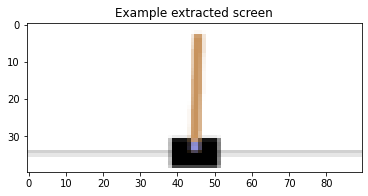

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # gym이 요청한 화면은 400x600x3 이지만, 가끔 800x1200x3 처럼 큰 경우가 있습니다.
    # 이것을 Torch order (CHW)로 변환한다.
    screen = env.render().transpose((2, 0, 1))
    # 카트는 아래쪽에 있으므로 화면의 상단과 하단을 제거하십시오.
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 카트를 중심으로 정사각형 이미지가 되도록 가장자리를 제거하십시오.
    screen = screen[:, :, slice_range]
    # float 으로 변환하고,  rescale 하고, torch tensor 로 변환하십시오.
    # (이것은 복사를 필요로하지 않습니다)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 크기를 수정하고 배치 차원(BCHW)을 추가하십시오.
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## 학습

### 하이퍼 파라미터와 유틸리티
이 셀은 모델과 최적화기를 인스턴스화하고 일부 유틸리티를 정의합니다:

-  ``select_action`` - Epsilon Greedy 정책에 따라 행동을 선택합니다.
   간단히 말해서, 가끔 모델을 사용하여 행동을 선택하고 때로는 단지 하나를
   균일하게 샘플링할 것입니다. 임의의 액션을 선택할 확률은
   ``EPS_START`` 에서 시작해서 ``EPS_END`` 를 향해 지수적으로 감소할 것입니다.
   ``EPS_DECAY`` 는 감쇠 속도를 제어합니다.
-  ``plot_durations`` - 지난 100개 에피소드의 평균(공식 평가에서 사용 된 수치)에 따른
   에피소드의 지속을 도표로 그리기 위한 헬퍼. 도표는 기본 훈련 루프가
   포함 된 셀 밑에 있으며, 매 에피소드마다 업데이트됩니다.




In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# AI gym에서 반환된 형태를 기반으로 계층을 초기화 하도록 화면의 크기를
# 가져옵니다. 이 시점에 일반적으로 3x40x90 에 가깝습니다.
# 이 크기는 get_screen()에서 고정, 축소된 렌더 버퍼의 결과입니다.
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# gym 행동 공간에서 행동의 숫자를 얻습니다.
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            # 최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            # 기대 보상이 더 큰 행동을 선택할 수 있습니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

### 학습 루프

최종적으로 모델 학습을 위한 코드.

여기서, 최적화의 한 단계를 수행하는 ``optimize_model`` 함수를 찾을 수 있습니다.
먼저 배치 하나를 샘플링하고 모든 Tensor를 하나로 연결하고
$Q(s_t, a_t)$ 와  $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ 를 계산하고
그것들을 손실로 합칩니다. 우리가 설정한 정의에 따르면 만약 $s$ 가
마지막 상태라면 $V(s) = 0$ 입니다.
또한 안정성 추가 위한 $V(s_{t+1})$ 계산을 위해 목표 네트워크를 사용합니다.
목표 네트워크는 대부분의 시간 동결 상태로 유지되지만, 가끔 정책
네트워크의 가중치로 업데이트됩니다.
이것은 대개 설정한 스텝 숫자이지만 단순화를 위해 에피소드를 사용합니다.




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). 이것은 batch-array의 Transitions을 Transition의 batch-arrays로
    # 전환합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치 요소를 연결합니다
    # (최종 상태는 시뮬레이션이 종료 된 이후의 상태)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a) 계산 - 모델이 Q(s_t)를 계산하고, 취한 행동의 열을 선택합니다.
    # 이들은 policy_net에 따라 각 배치 상태에 대해 선택된 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    # non_final_next_states의 행동들에 대한 기대값은 "이전" target_net을 기반으로 계산됩니다.
    # max(1)[0]으로 최고의 보상을 선택하십시오.
    # 이것은 마스크를 기반으로 병합되어 기대 상태 값을 갖거나 상태가 최종인 경우 0을 갖습니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # 기대 Q 값 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber 손실 계산
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

아래에서 주요 학습 루프를 찾을 수 있습니다. 처음으로 환경을
재설정하고 ``상태`` Tensor를 초기화합니다. 그런 다음 행동을
샘플링하고, 그것을 실행하고, 다음 화면과 보상(항상 1)을 관찰하고,
모델을 한 번 최적화합니다. 에피소드가 끝나면 (모델이 실패)
루프를 다시 시작합니다.

아래에서 `num_episodes` 는 작게 설정됩니다. 노트북을 다운받고
의미있는 개선을 위해서 300 이상의 더 많은 에피소드를 실행해 보십시오.




In [ ]:
num_episodes = 50
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # 행동 선택과 수행
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # 새로운 상태 관찰
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동
        state = next_state

        # (정책 네트워크에서) 최적화 한단계 수행
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

    # 목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

다음은 전체 결과 데이터 흐름을 보여주는 다이어그램입니다.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

행동은 무작위 또는 정책에 따라 선택되어, gym 환경에서 다음 단계 샘플을 가져옵니다.
결과를 재현 메모리에 저장하고 모든 반복에서 최적화 단계를 실행합니다.
최적화는 재현 메모리에서 무작위 배치를 선택하여 새 정책을 학습합니다.
"이전" target_net은 최적화에서 기대 Q 값을 계산하는 데에도 사용되고,
최신 상태를 유지하기 위해 가끔 업데이트됩니다.




In [ ]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4,256)
        self.fc2 = nn.Linear(256,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
     
        
def main():
    env = gym.make('CartPole-v1')
    #env = gym.make('BeamRider-v0')
    
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(1000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()

        for t in range(600):
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            #env.render()
            #plt.imshow(env.render(mode='rgb_array'))
            print("# of episode :{}, avg score : {:.1f}, buffer size : {}, epsilon : {:.1f}%".format(n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0

    print("Learning Completed")
    return q
    
if __name__ == '__main__':
    q = main()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# of episode :20, avg score : 10.3, buffer size : 207, epsilon : 7.9%
# of episode :40, avg score : 9.8, buffer size : 402, epsilon : 7.8%
# of episode :60, avg score : 10.1, buffer size : 604, epsilon : 7.7%
# of episode :80, avg score : 9.8, buffer size : 800, epsilon : 7.6%
# of episode :100, avg score : 9.8, buffer size : 996, epsilon : 7.5%
# of episode :120, avg score : 9.8, buffer size : 1191, epsilon : 7.4%
# of episode :140, avg score : 9.4, buffer size : 1379, epsilon : 7.3%
# of episode :160, avg score : 9.8, buffer size : 1576, epsilon : 7.2%
# of episode :180, avg score : 9.8, buffer size : 1773, epsilon : 7.1%
# of episode :200, avg score : 9.6, buffer size : 1965, epsilon : 7.0%


<ipython-input-10-849d85b9ff2e>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


# of episode :220, avg score : 14.8, buffer size : 2260, epsilon : 6.9%
# of episode :240, avg score : 32.1, buffer size : 2903, epsilon : 6.8%
# of episode :260, avg score : 25.6, buffer size : 3416, epsilon : 6.7%
# of episode :280, avg score : 31.9, buffer size : 4054, epsilon : 6.6%
# of episode :300, avg score : 32.1, buffer size : 4696, epsilon : 6.5%
# of episode :320, avg score : 33.0, buffer size : 5357, epsilon : 6.4%
# of episode :340, avg score : 24.7, buffer size : 5851, epsilon : 6.3%
# of episode :360, avg score : 31.5, buffer size : 6481, epsilon : 6.2%
# of episode :380, avg score : 39.1, buffer size : 7263, epsilon : 6.1%
# of episode :400, avg score : 39.6, buffer size : 8056, epsilon : 6.0%
# of episode :420, avg score : 60.1, buffer size : 9259, epsilon : 5.9%
# of episode :440, avg score : 92.0, buffer size : 11100, epsilon : 5.8%
# of episode :460, avg score : 90.8, buffer size : 12915, epsilon : 5.7%
# of episode :480, avg score : 109.9, buffer size : 15113, eps

In [ ]:
import gym

def run(param):
  env = gym.make('CartPole-v1')
  frames = []

  for i_episode in range(5):
      observation = env.reset()
      for t in range(200):
          frames.append(env.render(mode = 'rgb_array'))
          # env.render()
          #print(observation)
          if param == 'zr':
            action = q.sample_action(torch.from_numpy(observation).float(), 0)
          elif param == 'op':
            action = q.sample_action(torch.from_numpy(observation).float(), max(0.01, 0.08 - 0.01*(t/200)))
          else:
            action = env.action_space.sample()

          observation, reward, done, info = env.step(action)
          #if done:
          #  print("Episode finished after {} timesteps".format(t+1))
          # break

  env.close()
  #display_frames_as_gif(frames)
  # print("end")
  return frames

In [ ]:
!pip install JSAnimation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


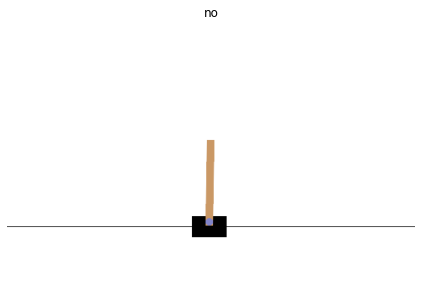

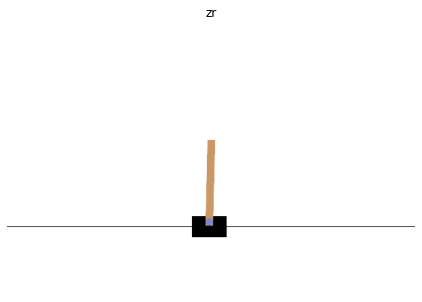

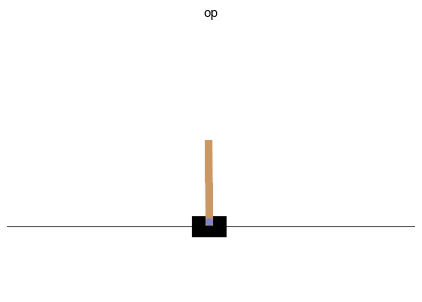

In [ ]:
# The typical imports 
import gym 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

# Imports specifically so we can render outputs in Jupyter. 
from JSAnimation.IPython_display import display_animation 
from matplotlib import animation 
from IPython.display import display 

def display_frames_as_gif(frames, title): 
    """ Displays a list of frames as a gif, with controls """ 
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)

    fig = plt.figure(figsize=(12,5))
    patch = plt.imshow(frames[0])
    plt.title(title)
    plt.axis('off') 
    
    def animate(i): 
        patch.set_data(frames[i]) 
        
    # anim = 
    # display(display_animation(anim, default_mode='loop'))
    # return animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50) 
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20) 
    return anim

frames = run('')
no = display_frames_as_gif(frames, 'no')

frames = run('op')
op = display_frames_as_gif(frames, 'op')

frames = run('zr')
zr = display_frames_as_gif(frames, 'zr')

In [ ]:
from IPython.display import HTML
HTML(no.to_html5_video())

In [ ]:
HTML(op.to_html5_video())

In [ ]:
HTML(zr.to_html5_video())